# 🔥Exploration 5. Spectrogram classification 모델 구현🔥

## 🎯프로젝트 목표🎯
### - 2차원 Spectrogram 데이터를 입력받아 이전 학습한 모델(1차원 Waveform 데이터를 입력받아 Text라벨을 출력하는 모델을 기본 버전과 Skip-connection 버전으로 나누어 학습)과 동일한 역할을 수행하는 모델 작성

## ✅프로젝트 순서✅
### 1. 데이터 처리와 분류
### 2. 학습을 위한 파라미터 설정
### 3. 데이터셋 구성
### 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성
### 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
### 6. Test dataset을 이용해서 모델의 성능을 평가
### 7. 루브릭 평가 및 회고

## 1. 데이터 처리와 분류
* ### 라벨 데이터 처리하기
* ### sklearn의 train_test_split함수를 이용해 train, test 분리


### 1-1. 데이터 불러오기 & 살펴보기

In [1]:
# 데이터 불러오기
import numpy as np
import os

data_path = os.getenv("HOME")+'/1.AIFFEL_Study/Exploration/E05_Audio_Recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("데이터 불러오기 완료")

데이터 불러오기 완료


In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' # 노드를 진행할때도 해당 코드를 한번 실행해주고 Tensorflow를 사용해보세요!

In [3]:
# 데이터 살펴보기
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("데이터 살펴보기 완료")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
데이터 살펴보기 완료


### >>> 데이터는 1초 길이이며, 50,620개를 가지고 있다.

In [4]:
import IPython.display as ipd

import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]//2))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])
print('rand:', rand)
ipd.Audio(data, rate=sr)

rand num :  43527
Wave data shape :  (8000,)
label :  ['unknown']
rand: 43527


### >>> 오디오 데이터에서 사용되는 sample rate=8000을 적용
### >>> 샘플 데이터 하나 청취: 오디오 확인!

## **❗2차원 Spectrogram 데이터변환**
### Spectrogram으로 변환하기 위해 파이썬에 있는 librosa 라이브러리 활용

In [5]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [6]:
spec_data = []
for wav in speech_data["wav_vals"][:len(speech_data["wav_vals"])//2]:
    spec_data.append(wav2spec(wav))
    
spec_arr = np.array(spec_data)
print(spec_arr.shape)
print(spec_arr[10]) # Spectrogram의 10번 데이터 확인

(25310, 130, 126)
[[8.9552603e-04 1.3810064e-03 1.6072338e-03 ... 2.0662896e-02
  7.1404278e-02 1.1528762e-01]
 [6.0091719e-05 1.0750835e-03 9.6700463e-04 ... 6.3589118e-02
  7.1058586e-02 1.8128322e-01]
 [1.1767675e-03 5.5588660e-04 3.7995775e-04 ... 1.0615811e-01
  2.9328763e-01 4.1529435e-01]
 ...
 [1.8260365e-05 9.7071952e-06 5.9431427e-06 ... 2.2589404e-05
  8.9194457e-04 1.7504499e-03]
 [1.6128397e-05 6.9310840e-06 4.3358773e-07 ... 2.9531270e-06
  8.8640873e-04 1.7095361e-03]
 [1.5151313e-05 8.8060378e-06 9.0604811e-07 ... 4.4976341e-06
  8.7678141e-04 1.6987949e-03]]


In [7]:
print("Waveform shape : ", speech_data["wav_vals"][10].shape)
print("Spectrogram shape : ", spec_arr[10].shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


### >>> Waveform 데이터: 1차원의 데이터이며 8000개
### >>> Spectrogram 데이터: 2차원 데이터로 변환! (130, 126)

## **❗2차원 Spectrogram 출력**

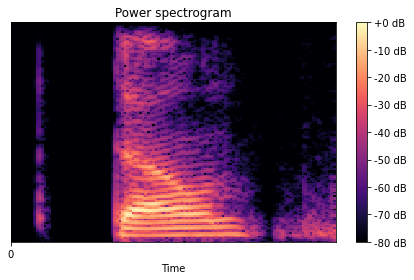

In [8]:
import librosa.display
import matplotlib.pyplot as plt

spec = spec_data[10]
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

### **1-2. train, test나누기 & 라벨링**
### - 현재 단어의 정답은 문자열이므로 학습가능한 형태(int, bool 등)로 변경 필요
### label 목록 = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go' ]
### 위 목록이외의 데이터들은 'unknown', 'silence'로 분류되어 있습니다.

## **❗라벨 출력 및 라벨별 숫자 부여(int로 변경해 학습에 이용하기 위함!!)**

In [9]:
# 라벨 출력 및 라벨별 숫자 부여(int로 변경해 학습에 이용하기 위함!!)

target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


## **❗라벨 데이터 만들기**

In [10]:
# 라벨 데이터 만들기

temp = []
for v in speech_data["label_vals"][:len(speech_data["label_vals"])//2]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

print(label_data)
print(len(label_data))

[3 3 3 ... 9 9 9]
25310


## **❗train, test 분리**

In [11]:
# train, test 분리

from sklearn.model_selection import train_test_split
sr = spec_arr.shape[1] 
sc = spec_arr.shape[2]
train_spectrogram, test_spectrogram, train_label, test_label = train_test_split(spec_arr, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

test_audio = test_spectrogram.copy()

train_spectrogram = train_spectrogram.reshape([-1, sr, sc, 1]) # add channel for CNN # reshape할 때 리스트 사용해도 무방
test_spectrogram = test_spectrogram.reshape([-1, sr, sc, 1]) # (22779, 130, 126, 1)
print(train_spectrogram.shape)

(22779, 130, 126, 1)


In [12]:
# reshape에 대한 고찰
# -1은 사용자가 계산하기 어려울 때 자동으로 컴퓨터에게 계산을 요청할 때 사용
# 예시) (4*5) array를 (2,10)으로 변경할 때 reshape(2,-1) 또는 (-1,10)을 사용

import tensorflow as tf
type(train_spectrogram)
test_spectrogram_ = test_spectrogram.copy()
# test_spectrogram_ = test_spectrogram_.reshape([-1,sr,sc,1]) # list = (2531,130,126,1)
test_spectrogram_ = tf.reshape(test_spectrogram_, [-1,sr,sc,1]) # 텐서를 reshape를 할 때는 tf 사용
test_spectrogram_.shape

TensorShape([2531, 130, 126, 1])

In [13]:
del spec_data
del speech_data
del spec_arr
del spec

## **❗분리된 데이터 확인**
### >>> Train: 총 50620개 중 90%인 45558개
### >>> Test: 총 50620개 중 10%인 5062개

In [14]:
# 분리된 데이터 확인

print("train data : ", train_spectrogram.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_spectrogram.shape)
print("test labels : ", test_label.shape)

train data :  (22779, 130, 126, 1)
train labels :  (22779,)
test data :  (2531, 130, 126, 1)
test labels :  (2531,)


## 2. 학습을 위한 파라미터 설정

## **❗파라미터 설정**
### >>> 모델 체크포인트 저장을 위한 체크포인트 경로 설정
### >>> 나중에 모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올 때 사용!
### >>> 배치사이즈 = 32 (전체 데이터를 10개 단위로 쪼개어 학습 진행)
### >>> 최대epoch = 10 (학습을 진행 시 최대 몇회까지 학습을 할 것인지 지정)

In [15]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/1.AIFFEL_Study/Exploration/E05_Audio_Recognition//models/wav'

checkpoint_dir

'/home/aiffel-dj40/1.AIFFEL_Study/Exploration/E05_Audio_Recognition//models/wav'

## 3. 데이터셋 구성
* ### tf.data.Dataset 이용
* ### from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
* ### map과 batch를 이용한 데이터 전처리
* ### 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다. tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다. 

## **❗one_hot 메소드 활용**

In [16]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


## **❗tf.data.Dataset 함수 구성**
### Tensorflow에 포함된 이 데이터셋 관리 패키지는 데이터셋 전처리, 배치처리 등을 쉽게 할 수 있게 한다.
### tf.data.Dataset.from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용할 수 있다.

In [17]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spectrogram, train_label))
train_dataset = train_dataset.map(one_hot_label) # from_tensor_slice에 입력한 튜플 형태로 데이터를 받으려 리턴값으로 어떤 데이터 반환할 지 결정
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


In [18]:
# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spectrogram, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성
* ### 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
* ### batchnorm, dropout, dense layer 등을 이용
* ### 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
* ### 모델 가중치를 저장하는 checkpoint callback 함수 추가
* ### 다양한 모델의 실험을 진행해 보시기 바랍니다.

## **❗모델 설계 (1) - Conv1D**

In [19]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr,sc,))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spectrogram = tf.keras.Model(input_tensor, output_tensor)

model_spectrogram.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

## **❗12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용**
### class를 구분하기 위해 multi-class classification 사용, 이를 수행하기 위한 loss로 Categorical Cross-Entropy loss사용

In [20]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spectrogram.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


## **❗callback**
### model.fit 사용시 callback함수를 이용해 학습 중간 원하는 동작을 하도록 설정 가능
### 모델 재사용을 위해 가중치를 저장하는 callback 함수 추가
### ModelCheckpoin메소드는 학습을 진행하며 다양한 인자를 지정해서 모니터하며 동작하게 설정할 수 있다.
### 아래는 검증 loss가 낮아지면 모델 파라미터를 저장하도록 구성.

In [21]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


## **❗학습 (1) - Conv1D**
### 배치 사이즈 = 32, 최대epoch = 10으로 설정함(파라미터 설정 부분에서 정의함)

In [22]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_spectrogram = model_spectrogram.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spectrogram) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spectrogram) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
706/711 [============================>.] - ETA: 0s - loss: 1.5422 - accuracy: 0.4713
Epoch 00001: val_loss improved from inf to 1.07369, saving model to /home/aiffel-dj40/1.AIFFEL_Study/Exploration/E05_Audio_Recognition//models/wav
711/711 [==============================] - 6s 8ms/step - loss: 1.5387 - accuracy: 0.4725 - val_loss: 1.0737 - val_accuracy: 0.6262
Epoch 2/10
708/711 [============================>.] - ETA: 0s - loss: 0.8437 - accuracy: 0.7085
Epoch 00002: val_loss improved from 1.07369 to 0.66623, saving model to /home/aiffel-dj40/1.AIFFEL_Study/Exploration/E05_Audio_Recognition//models/wav
711/711 [==============================] - 6s 8ms/step - loss: 0.8430 - accuracy: 0.7086 - val_loss: 0.6662 - val_accuracy: 0.7729
Epoch 3/10
709/711 [============================>.] - ETA: 0s - loss: 0.5441 - accuracy: 0.8158
Epoch 00003: val_loss improved from 0.66623 to 0.53566, saving model to /home/aiffel-dj40/1.AIFFEL_Study/Exploration/E05_Audio_Recognition//models/wav
7

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
* ### loss, accuracy를 그래프로 표현

## **❗학습결과 Plot (1) - Conv1D**
### history메소드를 활용해 저장된 정확도와 loss를 불러와 그래프 시각화 진행
### >>> epoch=2 이후부터 train_loss 와 val_loss 차이가 커져 오버피팅 의심

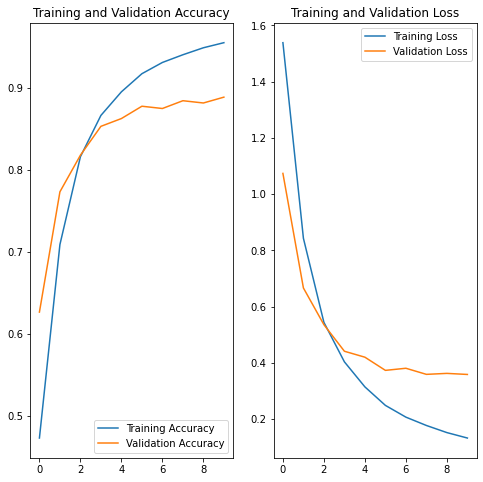

✅


In [23]:
import matplotlib.pyplot as plt

acc = history_spectrogram.history['accuracy']
val_acc = history_spectrogram.history['val_accuracy']

loss=history_spectrogram.history['loss']
val_loss=history_spectrogram.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

## 6. Test dataset을 이용해서 모델의 성능을 평가
* ### 저장한 weight 불러오기
* ### 모델의 예측값과 정답값이 얼마나 일치하는지 확인


## **❗모델 평가 (1) - Conv1D**
### checkpoint callback 함수가 저장한 weight를 다시 불러와서 테스트 준비

In [24]:
# 평가
model_spectrogram.load_weights(checkpoint_dir)
print("✅")

✅


## **❗Test data를 이용해 모델의 예측값과 실제값이 얼마나 일치하는지 확인 (1) - Conv1D**

In [25]:
# Test data을 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인하겠습니다.
results = model_spectrogram.evaluate(test_dataset)
print("✅")

80/80 [==============================] - 16s 196ms/step - loss: 0.3589 - accuracy: 0.8882
✅


In [26]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.359
accuracy value: 88.8187%
✅


## **❗Test data set을 골라 직접 들어보고 모델의 예측이 맞는지 확인 (1) - Conv1D**

In [27]:
label_value

{'yes': 0,
 'no': 1,
 'up': 2,
 'down': 3,
 'left': 4,
 'right': 5,
 'on': 6,
 'off': 7,
 'stop': 8,
 'go': 9,
 'unknown': 10,
 'silence': 11}

In [28]:
def spec2wav(wav):
    D = np.abs(librosa.istft(wav))
    return D

In [29]:
# Test data 셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인해 봅시다.
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spectrogram), size=1, replace=False)

batch_xs = test_spectrogram[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spectrogram(batch_xs, training=False)

# 위에서 확인해본 테스트셋의 라벨과 우리 모델의 실제 prediction 결과를 비교해 봅시다.
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: down(Correct!)


In [30]:
data_wav = []
for spec in test_audio:
    wav = spec2wav(spec)
    data_wav.append(wav)
data_wav = np.array(data_wav)
data_wav.shape

(2531, 8000)

In [31]:
import IPython.display as ipd

x = data_wav[batch_index]
print("label : ", str(inv_label_value[batch_ys[0]]))
ipd.Audio(x.reshape(8000,), rate=8000)

label :  down


## **❗모델 설계 (2) - Conv2D**

## ❗Conv2D 사용 (모델 설계부터 평가까지)

### Conv1D -> Conv2D
x = layers.Conv<span style="color:red">**1D**</span>(32, <span style="color:red">**9**</span>, padding='same', activation='relu')(input_tensor)

-> x = layers.Conv<span style="color:red">**2D**</span>(32, <span style="color:red">**(3,3)**</span>, padding = 'same', activation = 'relu')(input_tensor)

In [32]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr,sc,1))

x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_Spectrogram_2D = tf.keras.Model(input_tensor, output_tensor)

model_Spectrogram_2D.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0   

In [33]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_Spectrogram_2D.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [34]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spectrogram_2D'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [35]:
#30분 내외 소요
history_spectrogram_2D = model_Spectrogram_2D.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spectrogram) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spectrogram) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
583/711 [=======================>......] - ETA: 5s - loss: 0.9998 - accuracy: 0.6666

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

acc = history_spectrogram_2D.history['accuracy']
val_acc = history_spectrogram_2D.history['val_accuracy']

loss=history_spectrogram_2D.history['loss']
val_loss=history_spectrogram_2D.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [ ]:
# Evaluation 

model_Spectrogram_2D.load_weights(checkpoint_dir)
results = model_Spectrogram_2D.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

In [ ]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spectrogram), size=1, replace=False)

batch_xs = test_spectrogram[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_Spectrogram_2D(batch_xs, training=False)

if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

## **❗모델 설계 (3) - Skip-connection**

## ❗Skip-connection model 사용 (모델 설계부터 평가까지)

In [ ]:
input_tensor = layers.Input(shape=(sr,sc))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spectrogram_skip = tf.keras.Model(input_tensor, output_tensor)

model_spectrogram_skip.summary()

In [ ]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spectrogram_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

In [ ]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spectrogram_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

In [ ]:
#30분 내외 소요
history_spectrogram_skip = model_spectrogram_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spectrogram) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spectrogram) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

In [ ]:
import matplotlib.pyplot as plt

acc = history_spectrogram_skip.history['accuracy']
val_acc = history_spectrogram_skip.history['val_accuracy']

loss=history_spectrogram_skip.history['loss']
val_loss=history_spectrogram_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [ ]:
# Evaluation 

model_spectrogram_skip.load_weights(checkpoint_dir)
results = model_spectrogram_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

In [ ]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spectrogram), size=1, replace=False)

batch_xs = test_spectrogram[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spectrogram_skip(batch_xs, training=False)

if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

## 7. 루브릭 평가 및 회고

## <루브릭 평가>
### 1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.
### - 

### 2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.
### - 

### 3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준(75%이상)에 도달하였다.
### -

## <회고>
### - 